In [8]:
from pyemd import *
import numpy as np
import torch
from torch import optim
from torch.autograd import Variable
import pdb
import torch.nn.functional as F
from matplotlib import pyplot
import random

np.set_printoptions(precision=3)

### Let's test the EMD package

In [86]:
num_atoms = 50
MASS = 1

# we need to build a distance matrix (num_atoms x num_atoms) giving us the distance between the atoms
dist_matrix = np.zeros((num_atoms, num_atoms))

for i in range(num_atoms):
    for j in range(num_atoms):
        dist_matrix[i, j] = max(i - j, j - i)
        
def create_random_dist():
    # next, we build 2 different histograms, with the same amount of mass
    pmf = np.sort(np.random.uniform(high=MASS, size=[num_atoms - 1]))

    for i in range(num_atoms - 1):
        for j in range(i+1, num_atoms - 1):
            pmf[j] -= pmf[i]

    pmf = np.concatenate((pmf, [MASS - pmf.sum()])) / MASS
    
    return pmf
    
pmf_a, pmf_b = [create_random_dist() for _ in range(2)]
cost, transport_plan = emd_with_flow(pmf_a, pmf_b, dist_matrix)
transport_plan = np.array(transport_plan)

print transport_plan

[[0.006 0.    0.    ... 0.    0.    0.   ]
 [0.    0.006 0.    ... 0.    0.    0.   ]
 [0.    0.    0.031 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.026 0.    0.   ]
 [0.    0.    0.    ... 0.    0.006 0.   ]
 [0.    0.    0.    ... 0.001 0.001 0.018]]


### Wasserstein metric for discrete pmfs

$W(P,Q) = \sum_{i = 1}^{n_a} \sum_{j = 1}^{n_b} \gamma(x_i, x_j) \ || x_i - x_j ||$

In [35]:
# just to make sure I understand how the package works
def EMD_Loss(transport_plan, distance_matrix):
    return (transport_plan * distance_matrix).sum() 

print '{:.4f}, {:.4f}'.format(cost, EMD_Loss(transport_plan, dist_matrix))

2.1814, 2.1814


So our model will output the amount of mass to put on each atom. So the question is, what is the derivative of $W(P,Q)$ w.r.t the model's parameters?

In [57]:
def torch_EMD_loss(distance_matrix, source_distribution, transport_plan):
    '''
    transport_plan      : num_atoms x num_atoms
    distance_matrix     : num_atoms x num_atoms
    source_distribution : num_atoms
    '''
    source_distribution = source_distribution.unsqueeze(0).repeat(num_atoms, 1)
    normalized_plan = transport_plan / source_distribution.detach()
    cost = normalized_plan * distance_matrix * source_distribution
    return cost.sum()
    

### Experiments

In [81]:
def plot_dists(pmf_a, pmf_b, epoch, save=False):
    pyplot.bar(np.arange(num_atoms), pmf_a)
    pyplot.title('distributions at iteration {}'.format(epoch))
    pyplot.bar(np.arange(num_atoms), pmf_b, width=0.4)
    if save: 
        pyplot.savefig('emd/{}.png'.format(epoch))
    pyplot.show()


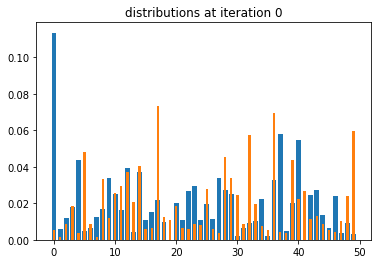

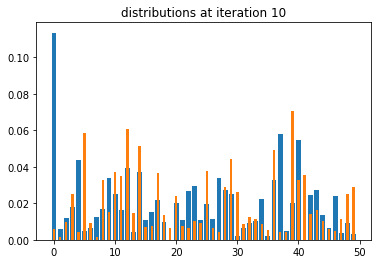

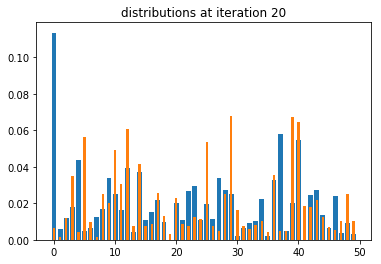

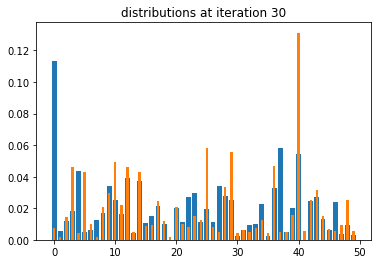

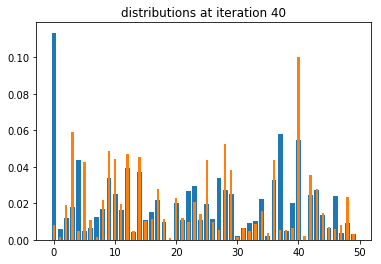

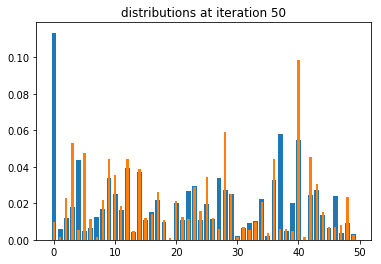

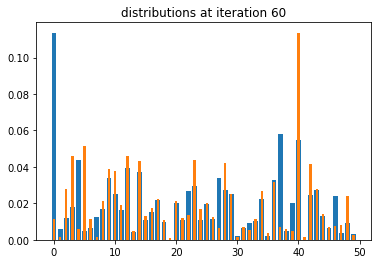

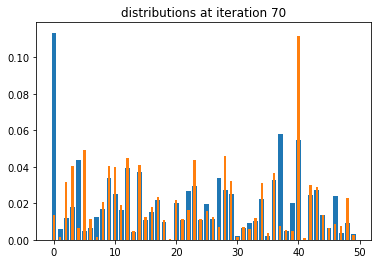

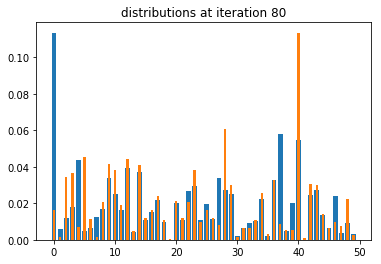

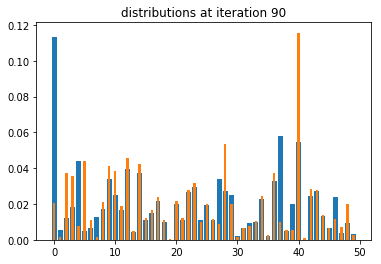

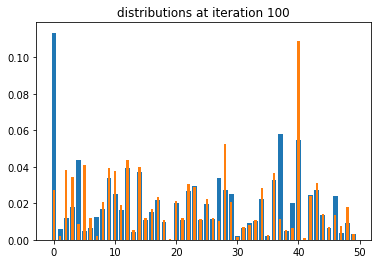

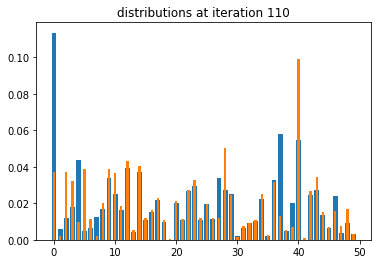

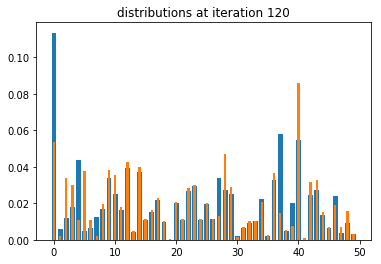

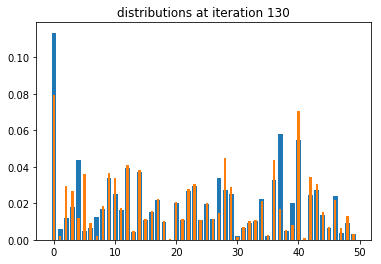

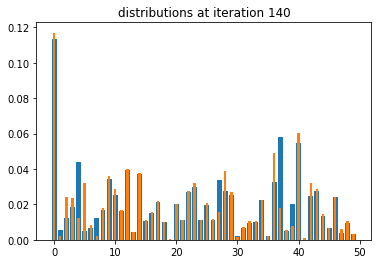

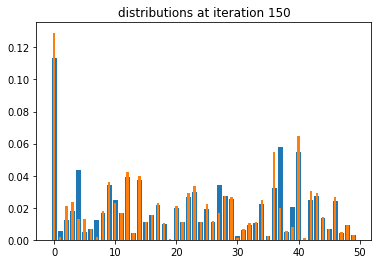

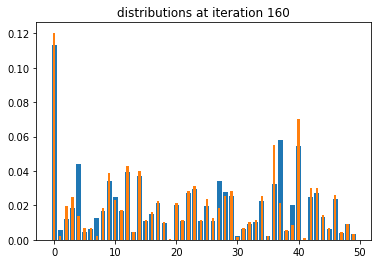

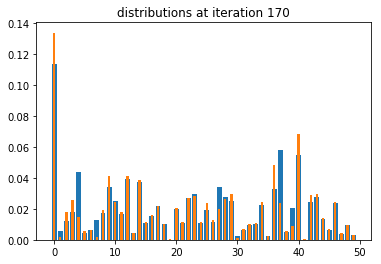

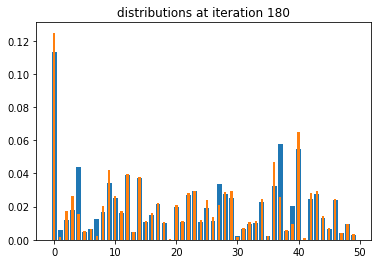

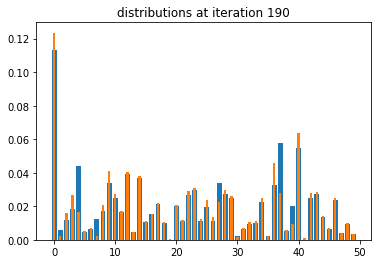

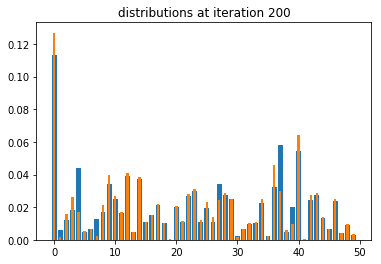

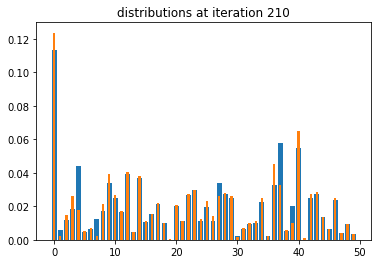

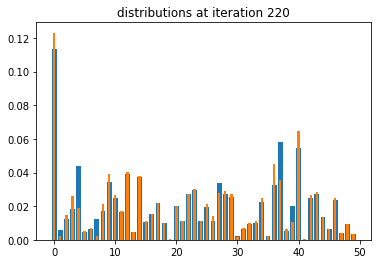

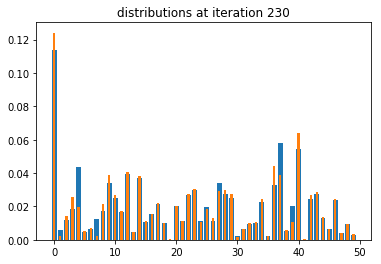

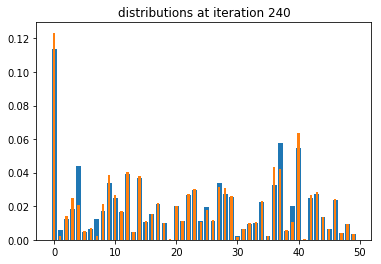

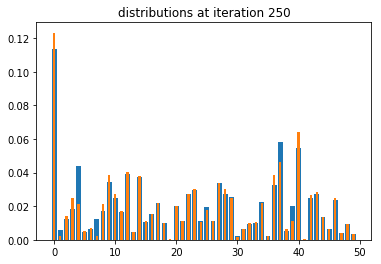

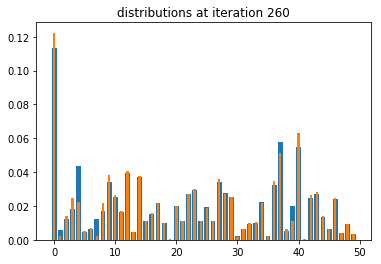

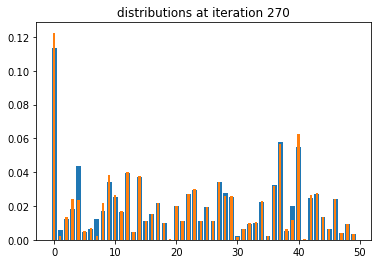

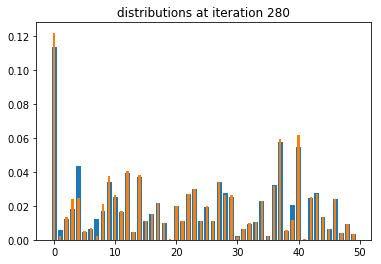

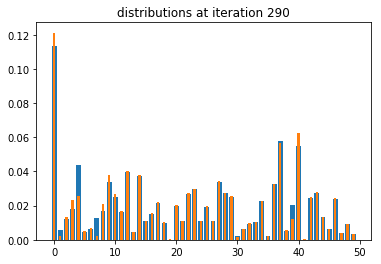

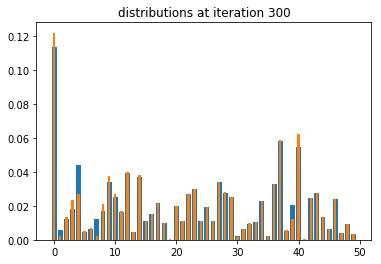

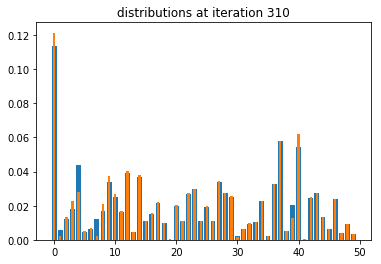

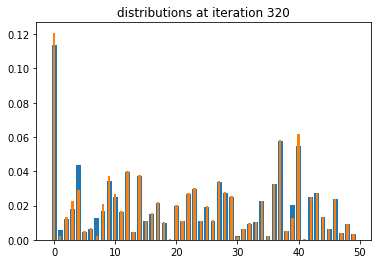

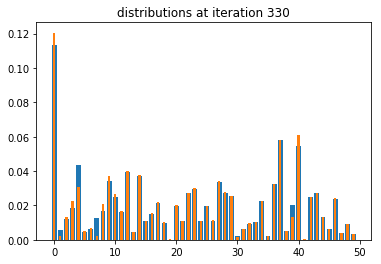

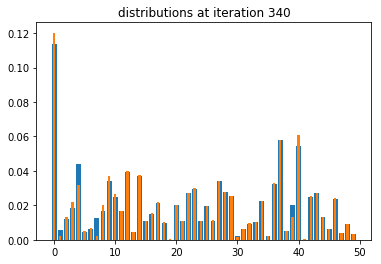

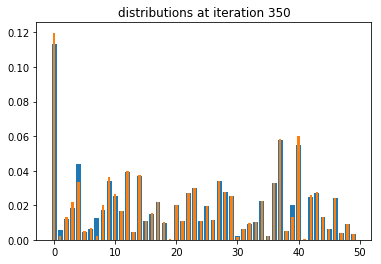

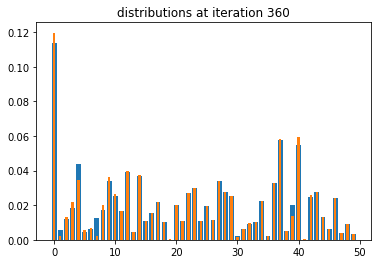

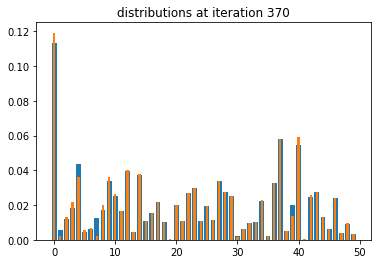

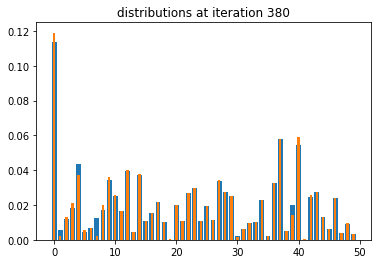

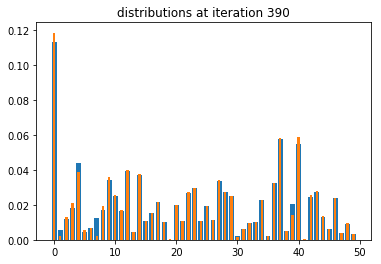

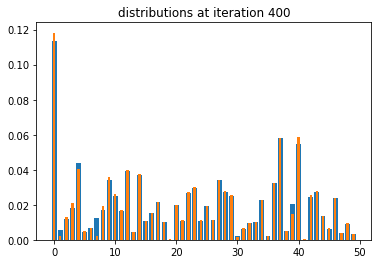

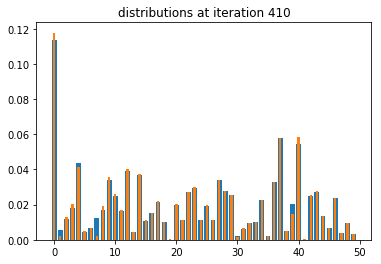

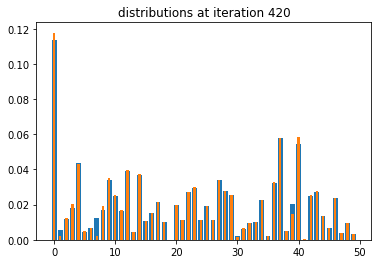

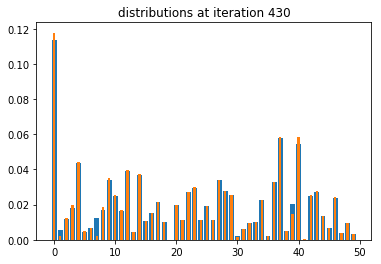

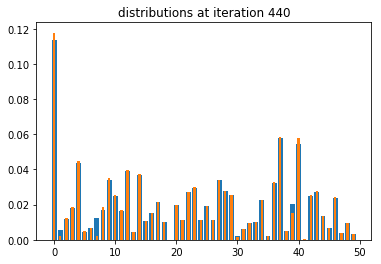

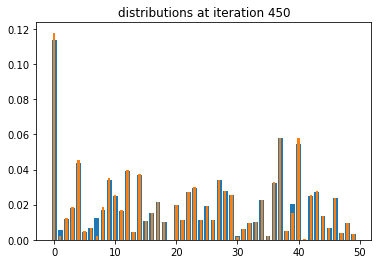

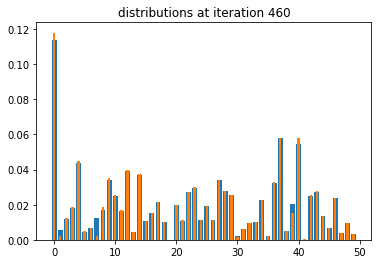

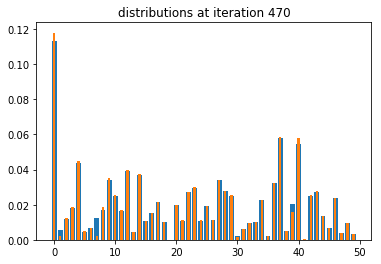

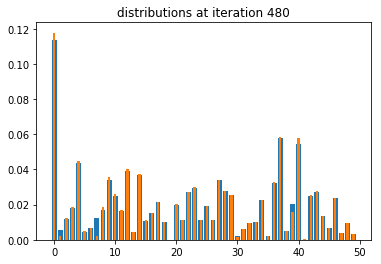

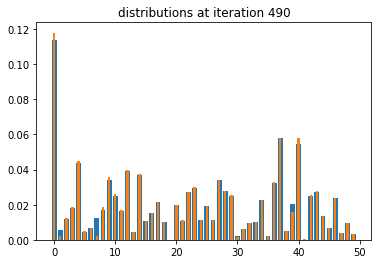

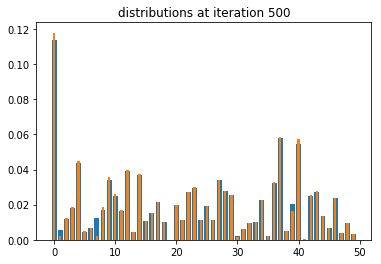

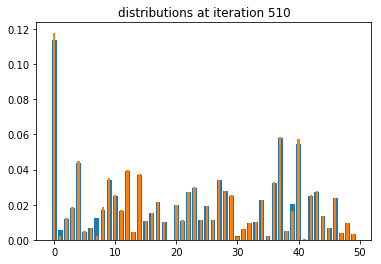

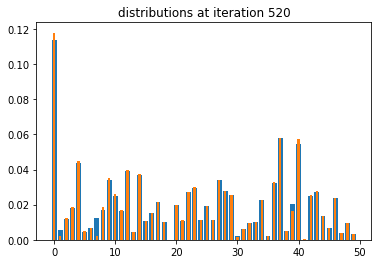

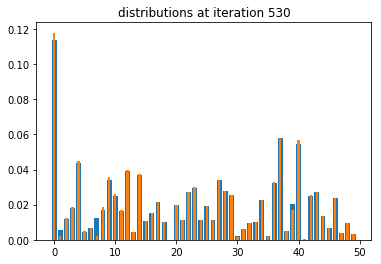

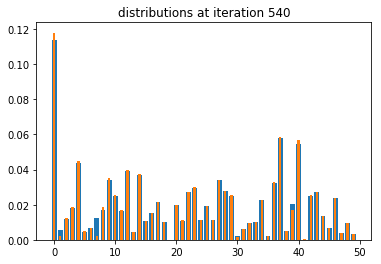

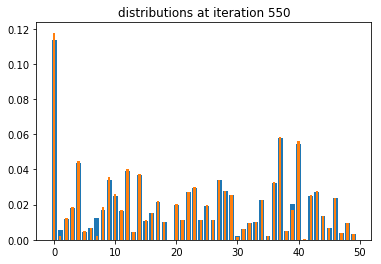

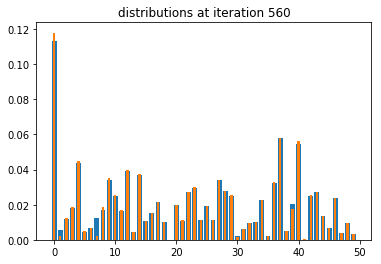

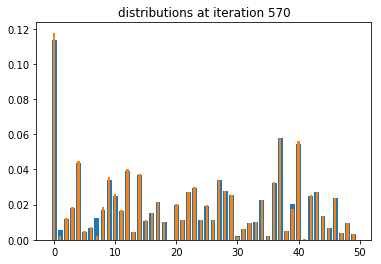

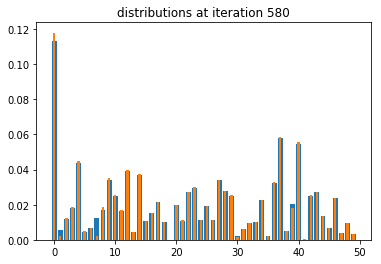

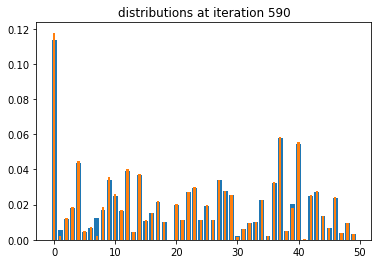

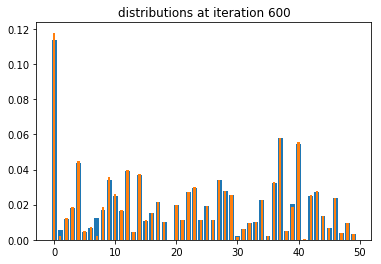

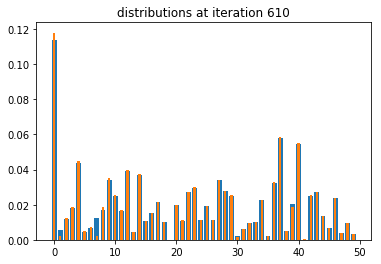

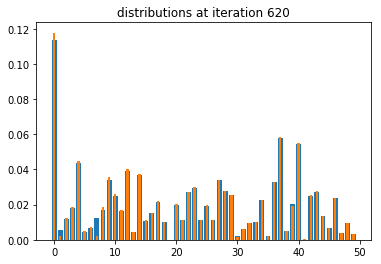

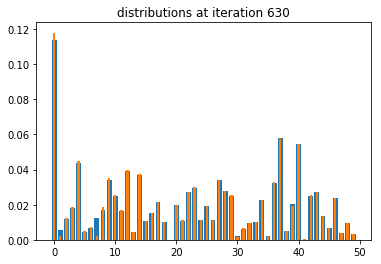

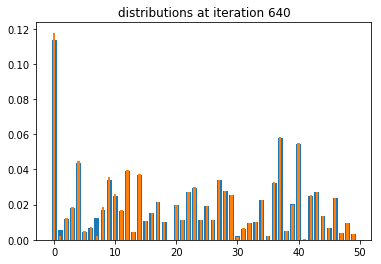

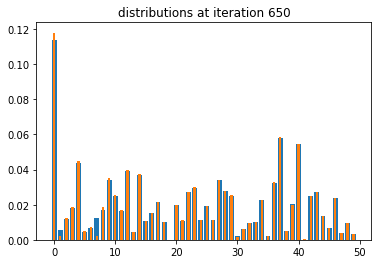

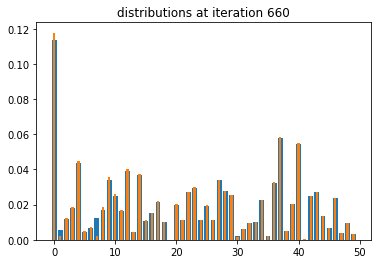

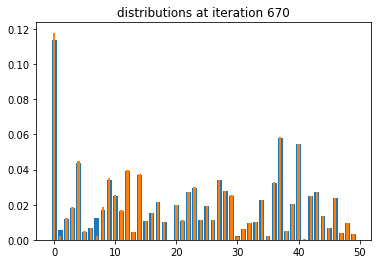

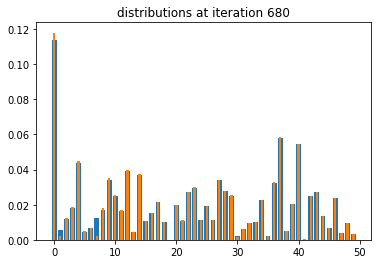

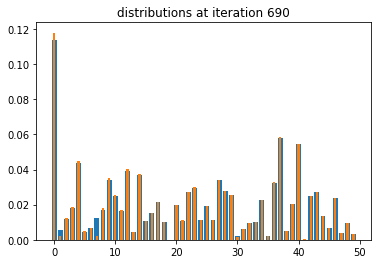

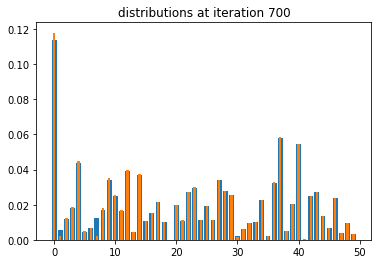

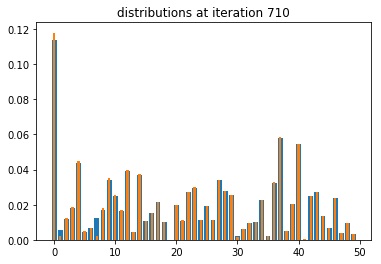

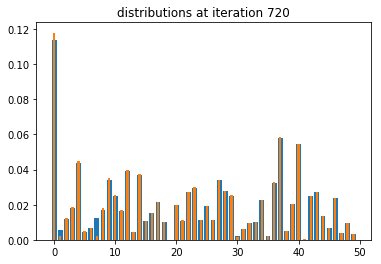

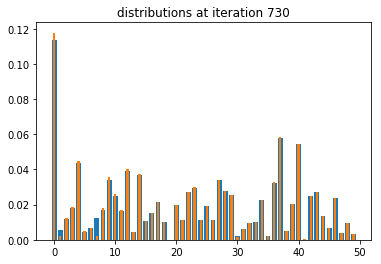

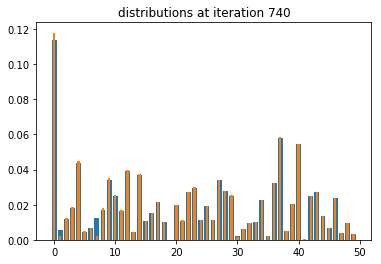

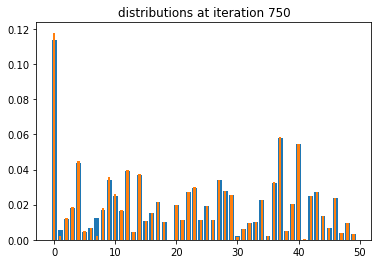

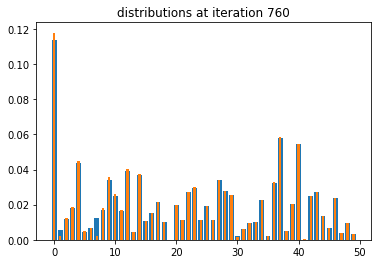

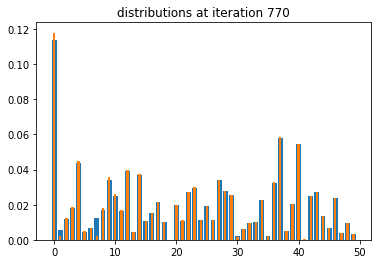

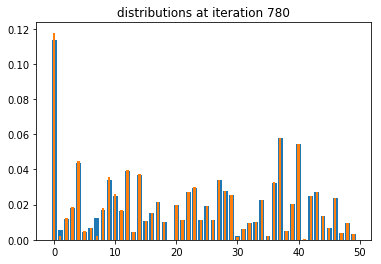

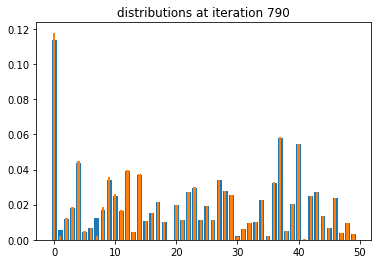

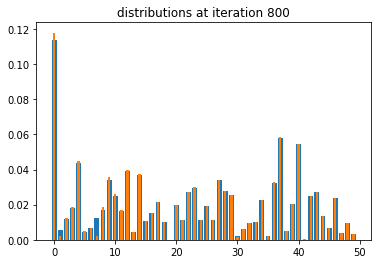

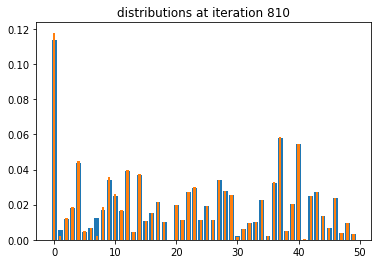

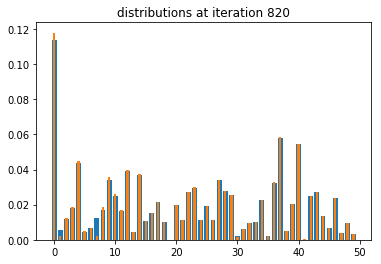

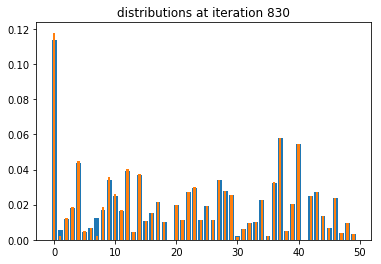

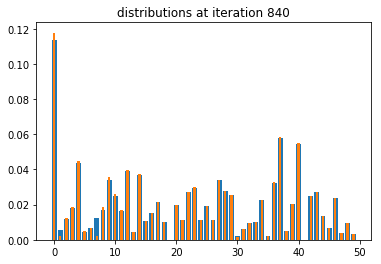

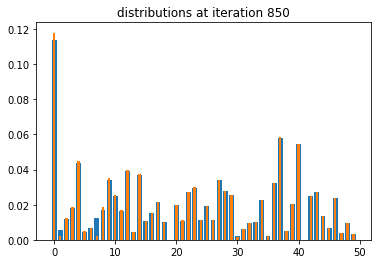

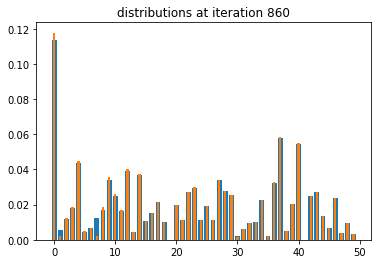

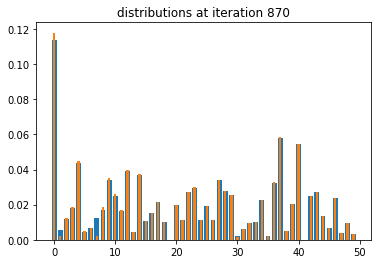

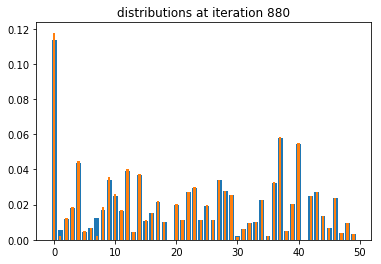

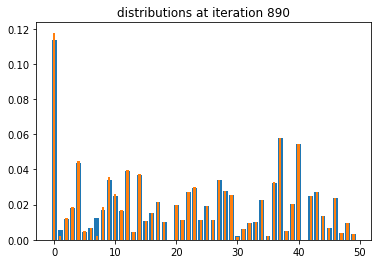

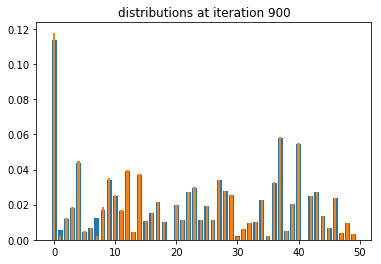

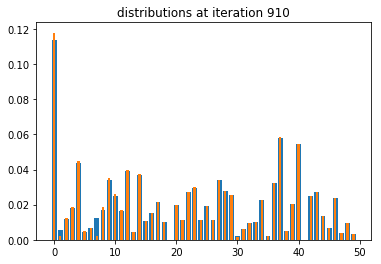

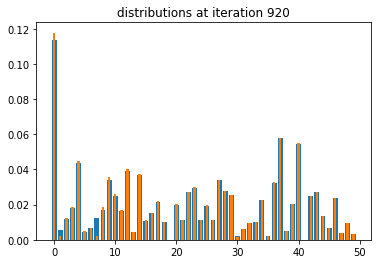

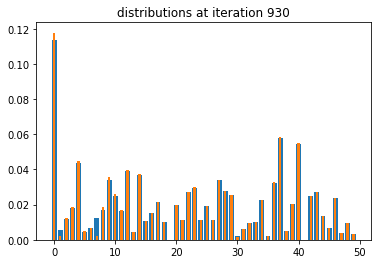

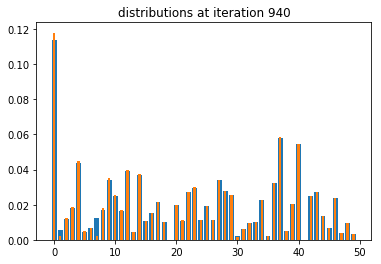

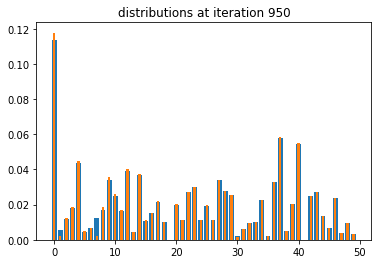

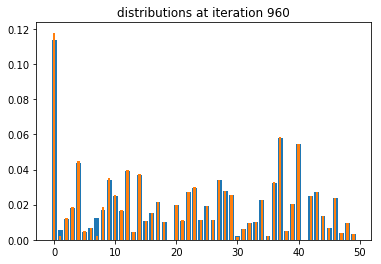

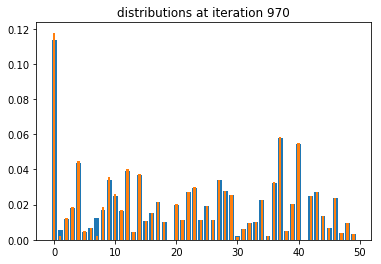

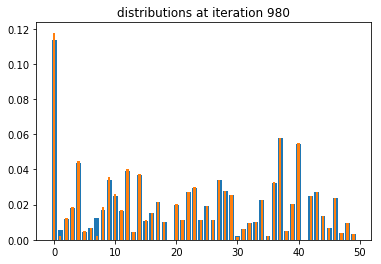

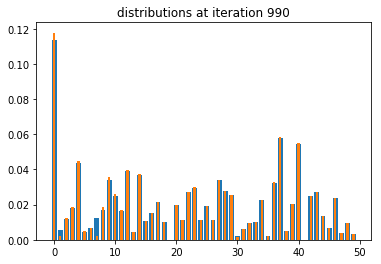

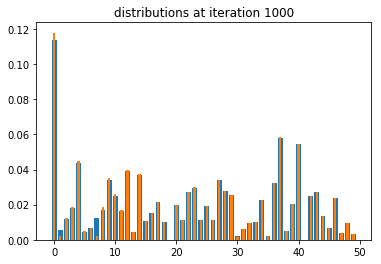

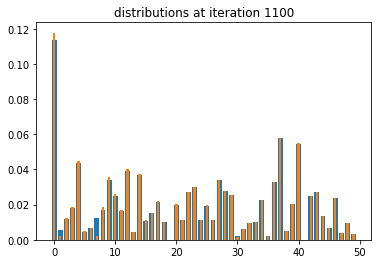

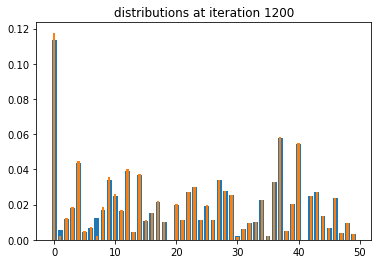

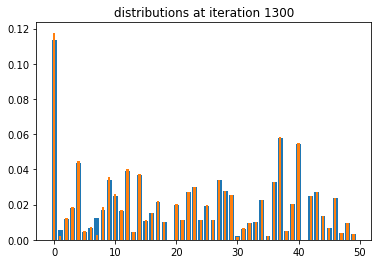

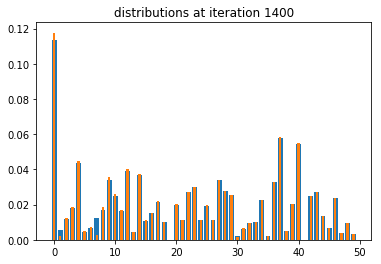

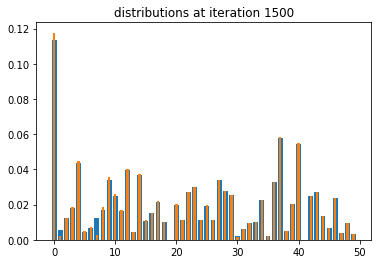

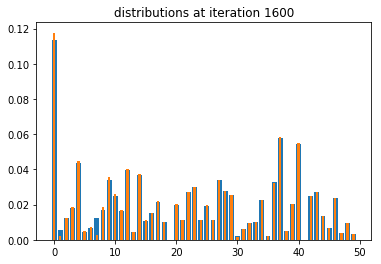

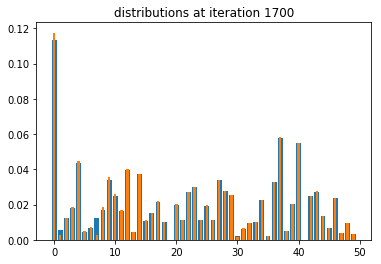

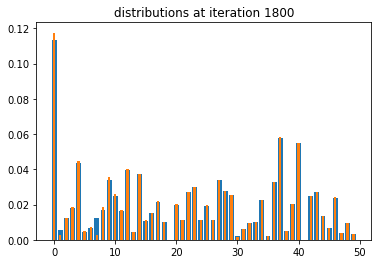

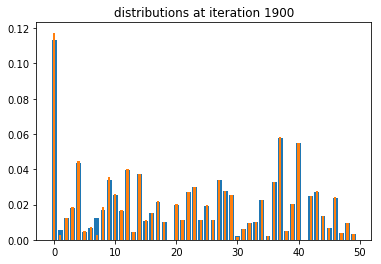

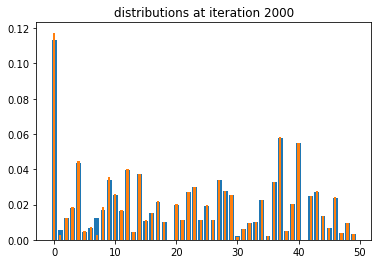

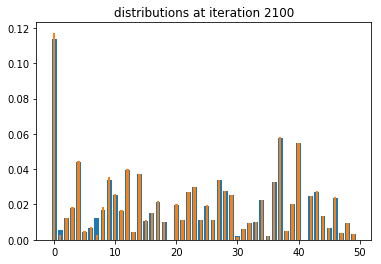

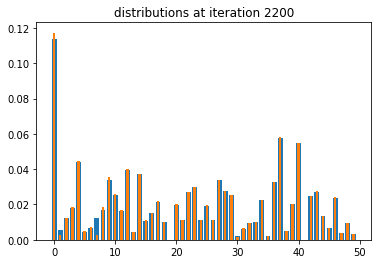

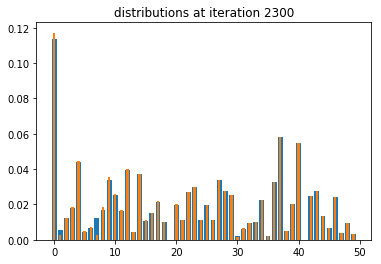

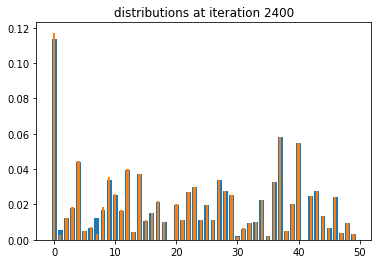

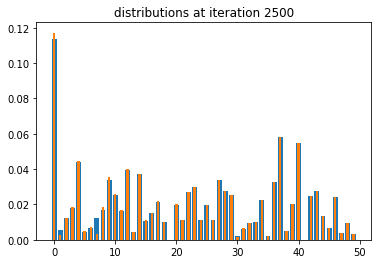

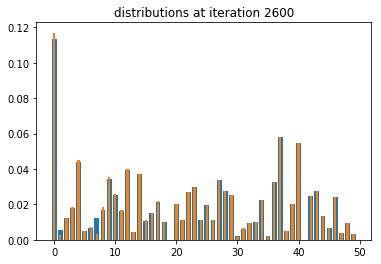

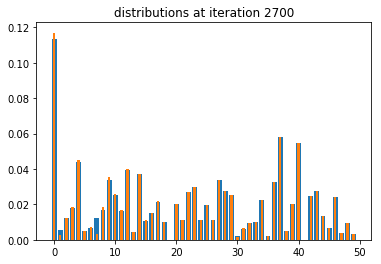

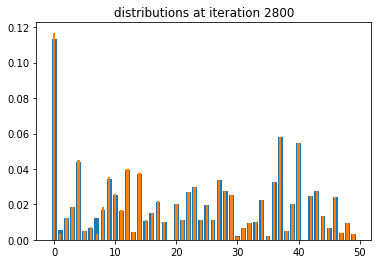

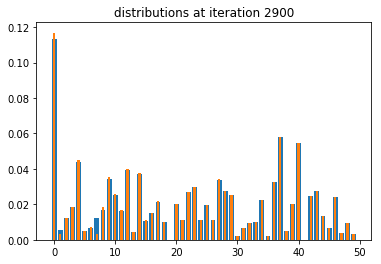

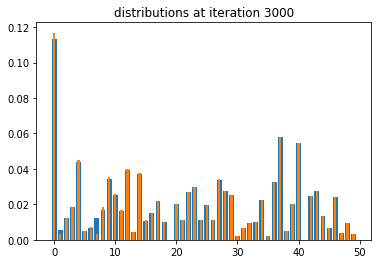

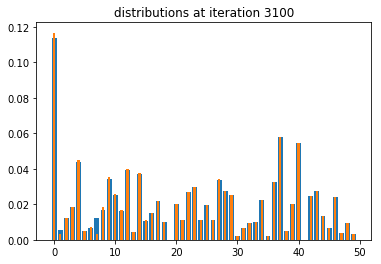

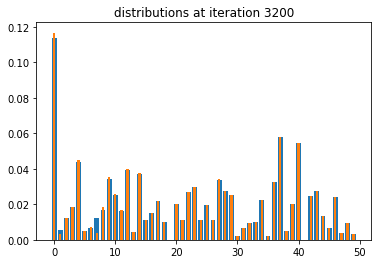

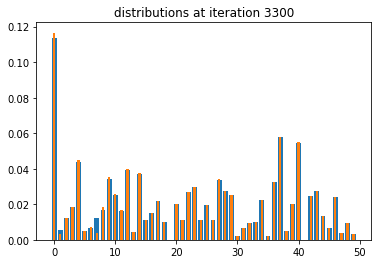

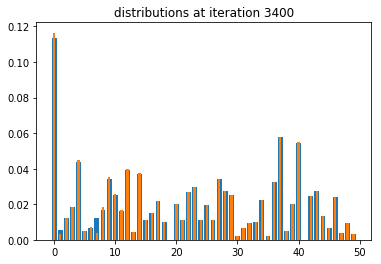

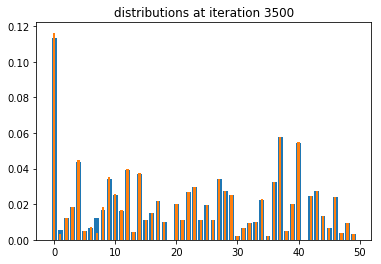

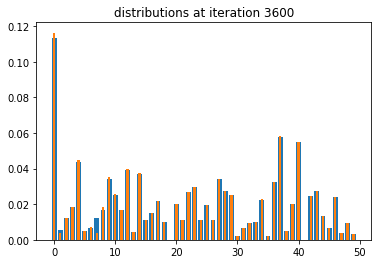

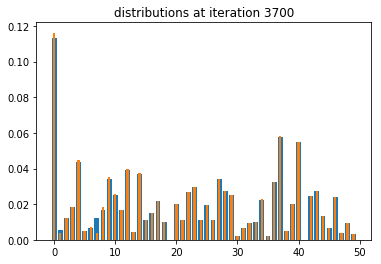

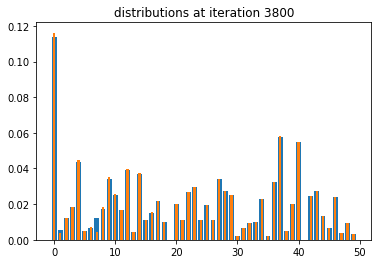

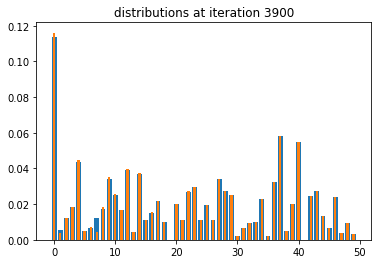

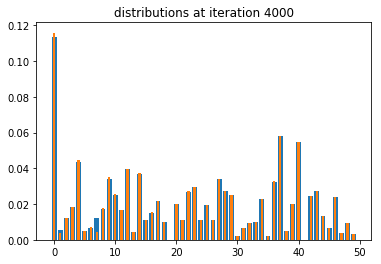

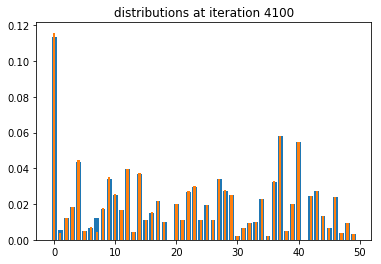

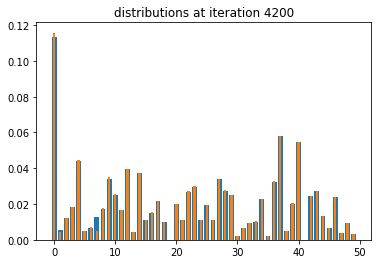

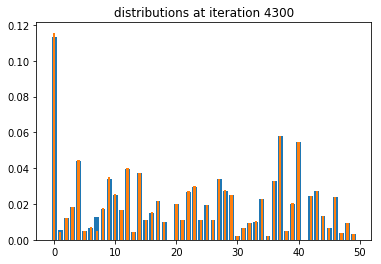

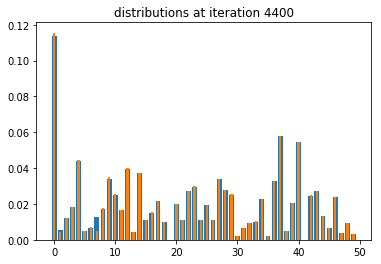

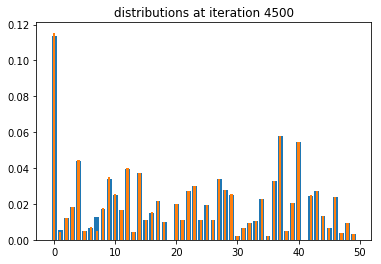

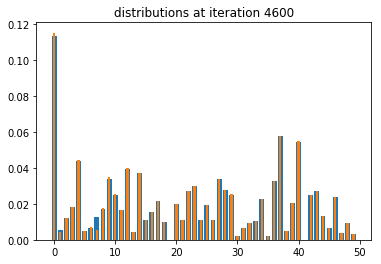

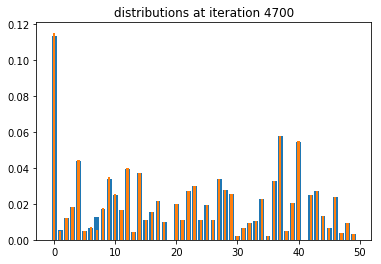

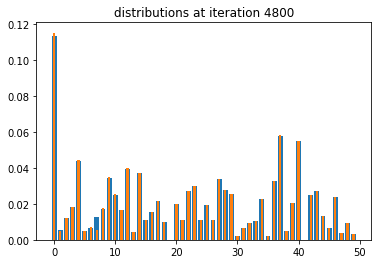

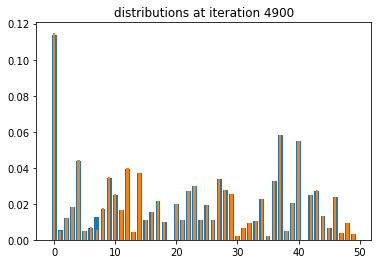

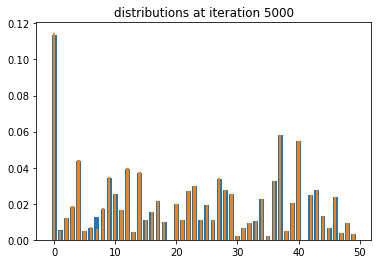

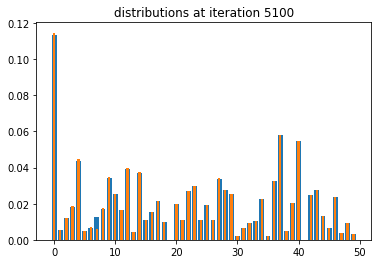

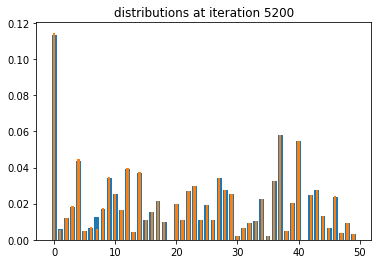

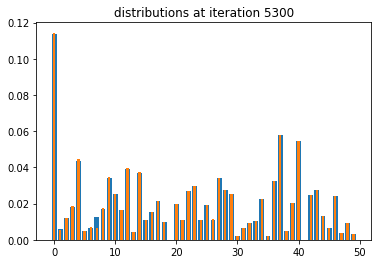

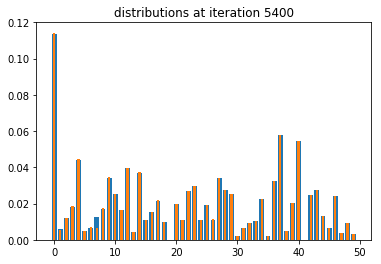

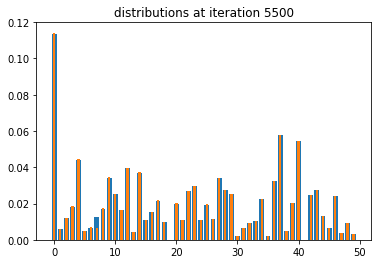

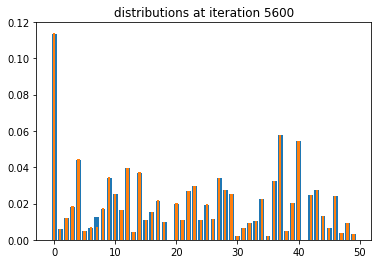

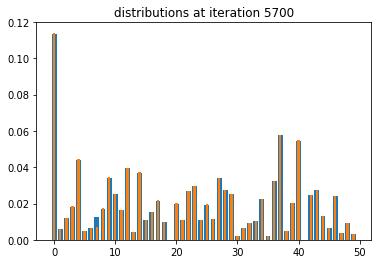

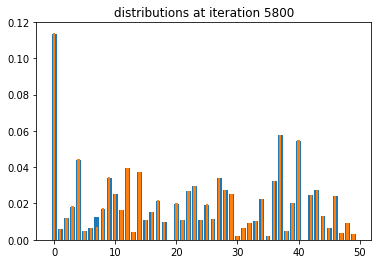

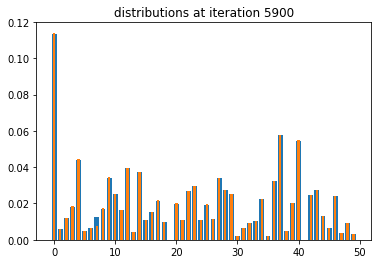

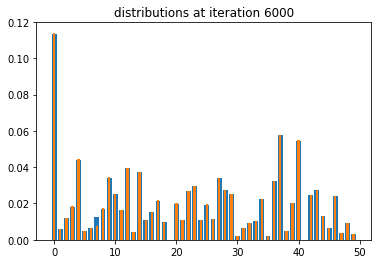

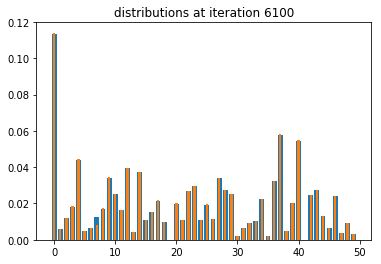

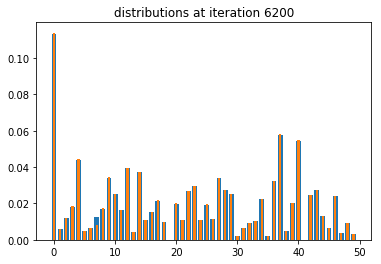

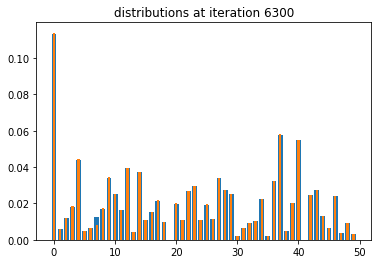

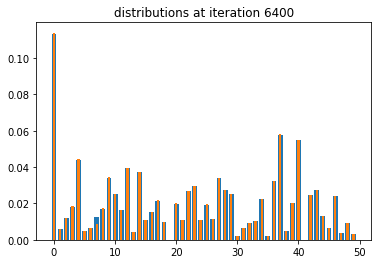

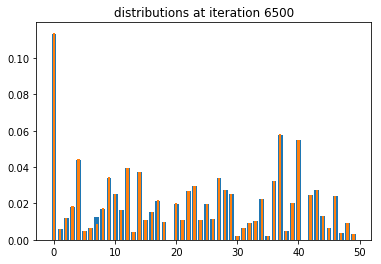

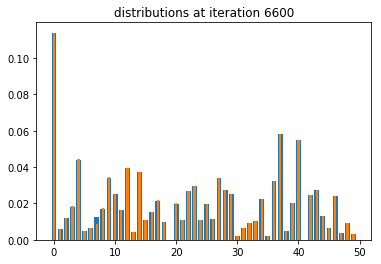

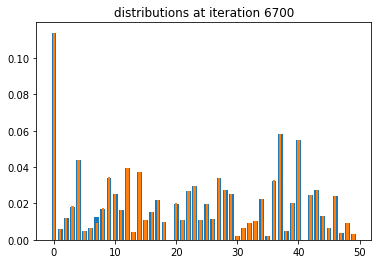

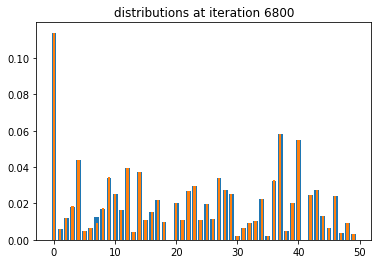

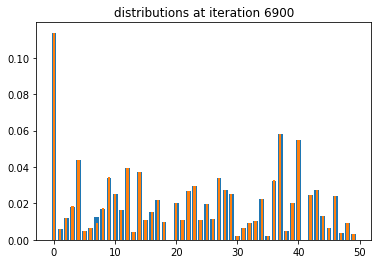

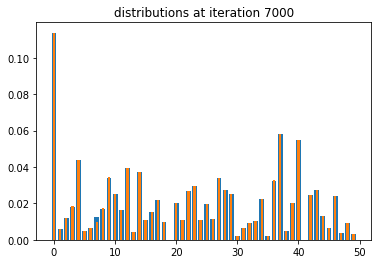

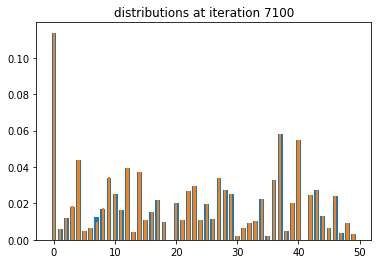

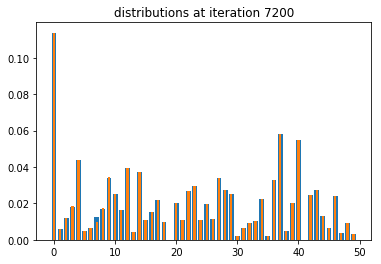

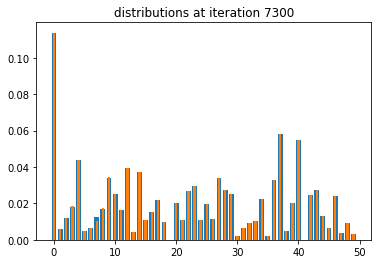

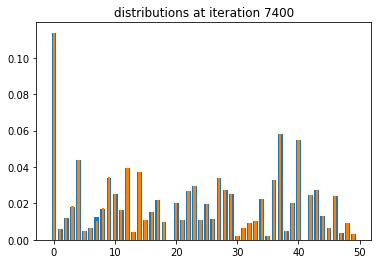

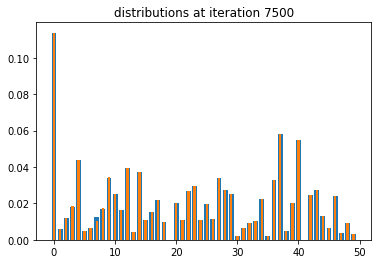

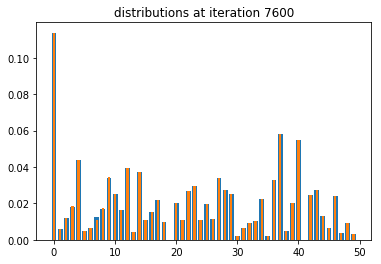

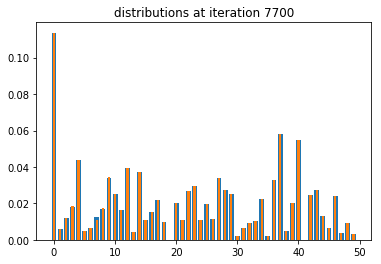

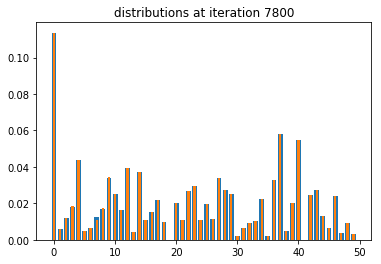

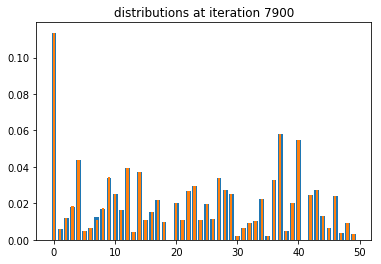

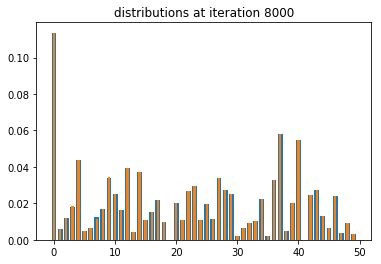

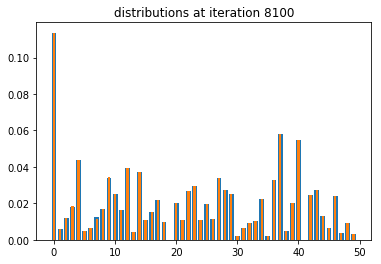

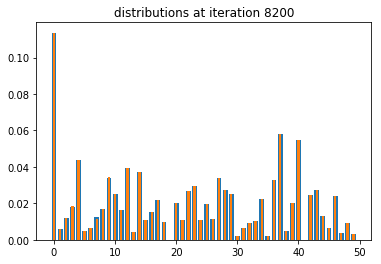

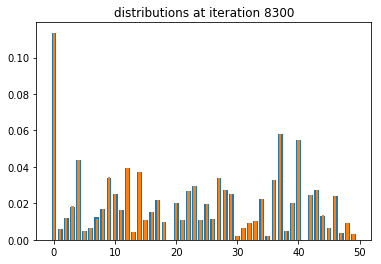

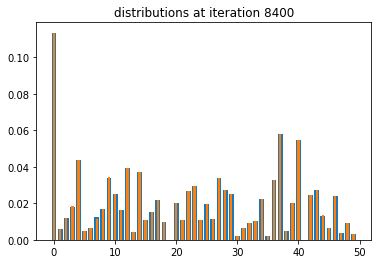

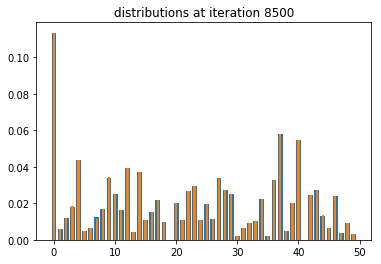

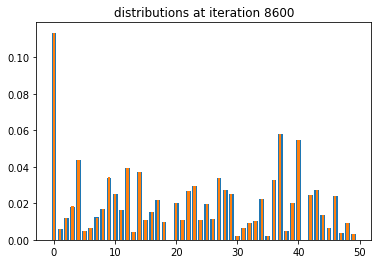

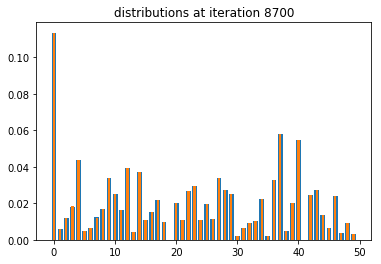

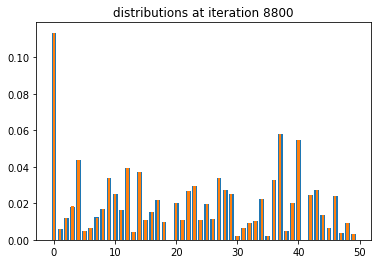

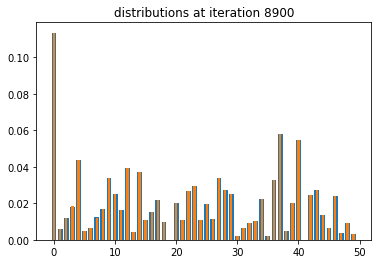

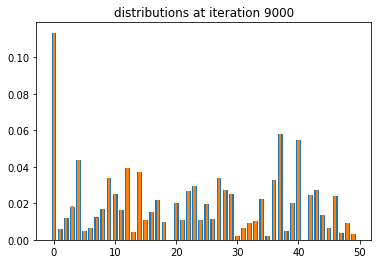

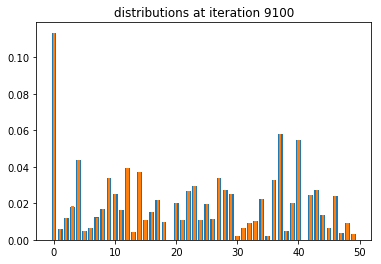

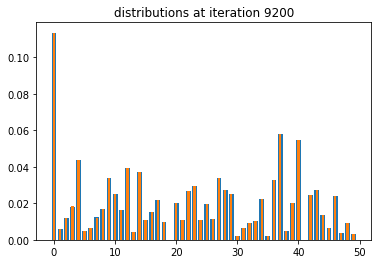

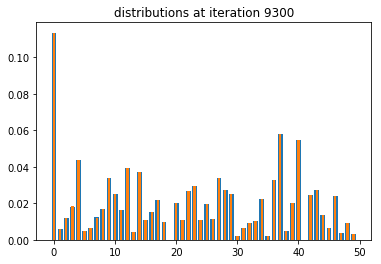

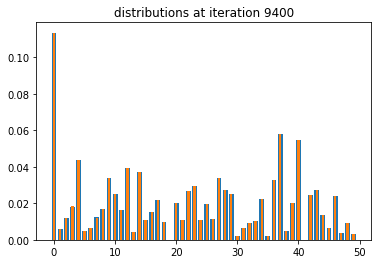

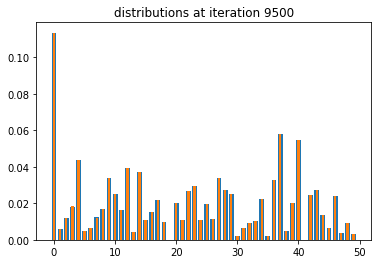

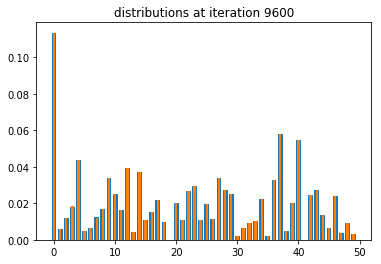

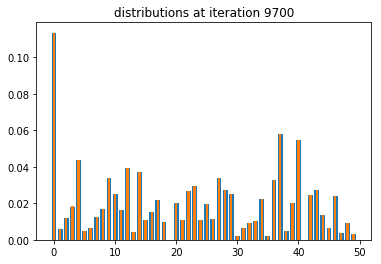

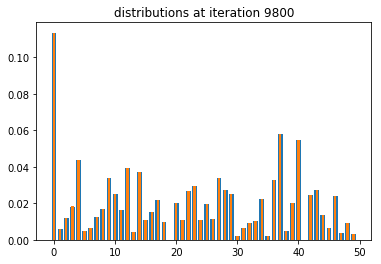

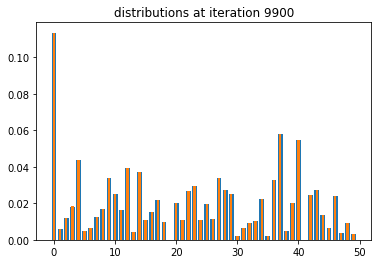

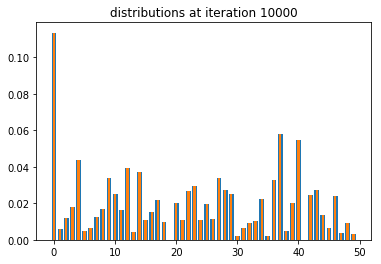

In [95]:
pmf_target = Variable(torch.from_numpy(create_random_dist()))
theta = Variable(torch.DoubleTensor(pmf_target.size()).normal_(), requires_grad=True)
dist_tensor = Variable(torch.from_numpy(dist_matrix))
optimizer = optim.SGD([theta], lr = 0.1, momentum=0.9)

for i in range(10001):
    pmf_theta = F.softmax(theta, dim=0)
    transport_plan = Variable(torch.from_numpy(np.array(emd_with_flow(pmf_target.data.numpy(), 
                                                                      pmf_theta.data.numpy(), 
                                                                      dist_matrix)[1])))
    
    loss = torch_EMD_loss(dist_tensor, pmf_theta, transport_plan)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i < 1000 and i % 10 == 0 or i % 100 == 0: 
        plot_dists(pmf_target.data.numpy(), pmf_theta.data.numpy(), i, save=True)
        

In [96]:
# let's save the plots as a gif 
import imageio
import os 

filenames = os.listdir('emd/')
filenames = [x for x in filenames if 'png' in x]
filenames = sorted(filenames, key = lambda x : int(x.split('.')[0]))

with imageio.get_writer('emd/fitting.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(os.path.join('emd', filename))
        writer.append_data(image)